In [35]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# Определение трансформаций для предобработки изображений
image_transform  = transforms.Compose([
    transforms.Resize((256, 256)),  # Изменение размера изображений
    transforms.ToTensor(),          # Преобразование в тензоры PyTorch
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Нормализация
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x)))  # Опционально, для бинаризации маски
])

import os
from PIL import Image
from torchvision import transforms
import torch

class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, masks_dir, image_transform=None, mask_transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # Предполагается, что файлы в images_dir и masks_dir имеют одинаковые имена и расположены в соответствующем порядке
        self.filenames = os.listdir(images_dir)

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.filenames[idx])
        
        # Загрузка изображения и маски
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Преобразование в grayscale

        if self.image_transform is not None:
            image = self.image_transform(image)
        if self.mask_transform is not None:
            mask = self.mask_transform(mask)

        return image, mask
dataset = CustomDataset(images_dir='/mnt/c/Users/victor/Downloads/FF++_Dataset/FF++_Dataset/ff++', 
                        masks_dir='/mnt/c/Users/victor/Downloads/FF++_Dataset/FF++_Dataset/ff++_mask_images', 
                        image_transform=image_transform, mask_transform=mask_transform)
# Создание DataLoader
dataloader = DataLoader(dataset, batch_size=128, shuffle=False, num_workers=32, pin_memory=True)


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} for training")

Using cuda for training


In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import numpy as np

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        # Адаптация для изображений 256x256
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)  # 128x128
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)  # 64x64
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)  # 32x32
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1)  # 16x16
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1)  # 8x8

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        # Обратная архитектура декодера
        self.conv_trans1 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_trans2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_trans3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_trans4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.conv_trans5 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1)  # Восстановление до 256x256

    def forward(self, x):
        x = F.relu(self.conv_trans1(x))
        x = F.relu(self.conv_trans2(x))
        x = F.relu(self.conv_trans3(x))
        x = F.relu(self.conv_trans4(x))
        x = torch.sigmoid(self.conv_trans5(x))
        return x

class SAMAE(nn.Module):
    def __init__(self):
        super(SAMAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x, mask):
        x_masked = x * mask
        encoded = self.encoder(x_masked)
        decoded = self.decoder(encoded)
        return decoded

import torch
import torchvision.models.detection as detection

def create_face_masks_with_detection(images_tensor):
    """
    Создает маски для лиц в батче изображений, используя модель обнаружения лиц на GPU.
    
    Параметры:
        images_tensor (torch.Tensor): Тензор изображений размером [batch_size, channels, height, width] на GPU.
    
    Возвращает:
        torch.Tensor: Тензор масок размером [batch_size, 1, height, width] на GPU.
    """
    device = images_tensor.device
    batch_size, channels, height, width = images_tensor.size()

    # Загружаем предварительно обученную модель обнаружения лиц (например, Faster R-CNN)
    model = detection.fasterrcnn_resnet50_fpn(pretrained=True)
    model = model.to(device)
    model.eval()

    with torch.no_grad():
        predictions = model(images_tensor)

    masks = torch.zeros(batch_size, 1, height, width, device=device)
    for i, prediction in enumerate(predictions):
        # Получаем координаты обнаруженных лиц для текущего изображения
        boxes = prediction['boxes']
        labels = prediction['labels']
        scores = prediction['scores']

        # Фильтруем результаты обнаружения (например, по классу и вероятности)
        for box, label, score in zip(boxes, labels, scores):
            if score > 0.5:  # Предполагаем, что класс лица имеет метку 1 (зависит от модели)
                x_min, y_min, x_max, y_max = box.int()
                masks[i, 0, y_min:y_max, x_min:x_max] = 1.0

    return masks


In [57]:
import torch
import torch.optim as optim

# Параметры для тренировки
num_epochs = 10
learning_rate = 0.001

# Инициализация модели, функции потерь и оптимизатора
model = SAMAE().to(device)
criterion = nn.MSELoss()  # Можно выбрать другую функцию потерь, если это целесообразно
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Тренировочный цикл
for epoch in range(num_epochs):
    for i, (images, masks) in enumerate(dataloader):
        images = images.to(device)
        masks = masks.to(device)
        
        # Forward pass
        outputs = model(images, masks)
        loss = criterion(outputs, images)  # Вычисление ошибки относительно оригинальных изображений
        
        # Backward и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(i)
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(dataloader)}], Loss: {loss.item()}')

# Сохранение модели
torch.save(model.state_dict(), 'samae_model.pth')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31


KeyboardInterrupt: 

In [55]:
def inference(model_path, image_path):
    # Загрузка модели
    model = SAMAE()
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Перевод модели в режим инференса

    # Загрузка и предобработка изображения
    image = Image.open(image_path)
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    image = transform(image).unsqueeze(0)  # Добавление размерности пакета

    # Создание маски
    # mask = create_face_masks_with_detection(image)  # Предполагается, что функция адаптирована для работы с путем к изображению
    # print(mask)
    mask = torch.ones(1, 256, 256)
    # Инференс
    with torch.no_grad():
        reconstructed_image = model(image, mask)
    
    return reconstructed_image

# Пример использования
reconstructed_image = inference('samae_model.pth', '/mnt/c/Users/victor/Downloads/FF++_Dataset/FF++_Dataset/ff++/raw_001_7.png')

reconstructed_image

tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 5.5213e-31],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00]],

         [[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 5.3323e-30],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          ...,
          [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000

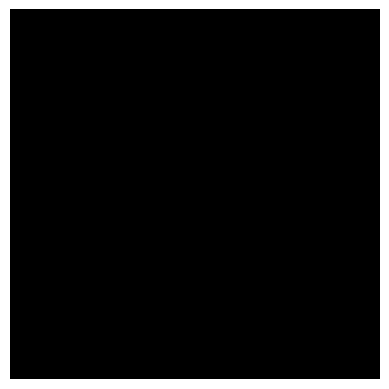

In [56]:
import matplotlib.pyplot as plt
import numpy as np

# Предполагается, что reconstructed_image - это тензор PyTorch размером [1, C, H, W] и данные в диапазоне [0, 1]
# Сначала удалим размер батча и переведем тензор в numpy массив
image_np = reconstructed_image.squeeze().cpu().detach().numpy()
image_np_correct_shape = np.transpose(image_np, (1, 2, 0))
# Отображаем изображение
plt.imshow(image_np_correct_shape)
plt.axis('off')  # Убираем оси для чистоты визуализации
plt.show()
